# Phyloseq operations

Phyloseq is a package made for organizing and working with microbiome data in R. With the phyloseq package we can have all our microbiome amplicon sequence data in a single R object. With functions from the phyloseq package, most common operations for preparing data for analysis is possible with few simple commands.

This document is an overview on how phyloseq objects are organized and how they can be accessed and changed.

The paper presenting phyloseq:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0061217

A comprehensive documetation of the phyloseq package:
https://joey711.github.io/phyloseq/

# Contents
* [Subset samples](#subdata)
* [Prune samples](#prunedata)
* [Subset taxa](#subtax)
* [Prune taxa](#prunetax)
* [Transform abundance](#trans)
* [Tax agglomoration](#agg)
* [Plot abundance](#plot)

In [2]:
# Load package and phyloseq object
library(phyloseq)
load("physeq.RData")

# Subset samples<a class="anchor" id="subdata"></a>

We can subset the the samples with the subset_samples function. We can subset based on any column in the sample_data:

In [3]:
sample_variables(phy)

[1] "Patient"  "Time"     "Delivery"

First argument to the subset_samples() function is the phyloseq object we want to subset.
In the second argument we tell the function how to subset.
Here we get the 1 week (1w) samples (always use two = signs)

In [4]:
phy_1w <- subset_samples(phy, Time == "1w")

Now we only have the 50 1 week samples in phy_1w

In [5]:
phy_1w

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1417 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1417 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1417 tips and 1414 internal nodes ]
refseq()      DNAStringSet:      [ 1417 reference sequences ]

We can also subset both 1 week and 1 month samples:

In [6]:
phy_1w1m <- subset_samples(phy, Time %in% c("1w", "1m"))
phy_1w1m

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1417 taxa and 100 samples ]
sample_data() Sample Data:       [ 100 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1417 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1417 tips and 1414 internal nodes ]
refseq()      DNAStringSet:      [ 1417 reference sequences ]

We can also subset on different variables at the same time. Here we only take 1 week samples from children born by C-section:

In [7]:
phy_1wS <- subset_samples(phy, Time == "1w" & Delivery == "Sectio")
phy_1wS

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1417 taxa and 15 samples ]
sample_data() Sample Data:       [ 15 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1417 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1417 tips and 1414 internal nodes ]
refseq()      DNAStringSet:      [ 1417 reference sequences ]

# Prune samples<a class="anchor" id="prunedata"></a>

We can also subset samples based on how many reads each sample have. 
sample_sums(phy) outputs the number of reads for each sample. Here we subset samples that have more than 5000 reads, and we can see that 2 samples have been thrown away:

In [8]:
phy_5k <- prune_samples(sample_sums(phy) > 5000, phy)
phy_5k

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1417 taxa and 148 samples ]
sample_data() Sample Data:       [ 148 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1417 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1417 tips and 1414 internal nodes ]
refseq()      DNAStringSet:      [ 1417 reference sequences ]

# Subset taxa<a class="anchor" id="subtax"></a>

In the same way as we can subset samples, we can also subset taxa. E.g. only Firmicutes:

In [9]:
phy_1wfirms <- subset_taxa(phy_1w, Phylum == "Firmicutes")

We can subset based on all the different taxonomic ranks:

In [10]:
rank_names(phy)

[1] "Kingdom"  "Phylum"   "Class"    "Order"    "Family"   "Genus"    "asv_hash"

Notice that we ran the above command on the phy_1w object that we created earlier.
Now we only have 1 week samples and only Firmicutes ASVs.
We can chain together all the different subsetting commands together to get exactly the subset of samples and taxa we want.

# Prune taxa<a class="anchor" id="prunetax"></a>

We can also prune taxa by how abundant they are.
A convenient function to do this is preDA from the DAtest package.
Load the package first:

In [12]:
library(DAtest)

We can filter low abundant taxa based on three criteria:
* They should be present in a minimum amount of samples (min.samples)
* They should have a minimum amount of reads (min.reads)
* They should have a minimum average relative abundance (min.abundance)

You don't have to use all three criteria.
The filtered taxa are grouped in a new taxa called "Others".

Below we only want taxa that are:
* at least present in 5 samples
* at least have a total of 10 reads

In [13]:
phy_abund <- preDA(phy, min.samples = 5, min.reads = 10)
phy_abund

669 features grouped as 'Others' in the output


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 749 taxa and 150 samples ]
sample_data() Sample Data:       [ 150 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 749 taxa by 7 taxonomic ranks ]

**Note on pruning taxa:** There are, unfortunately, no standards on how to set the thresholds when pruning low abundant ASVs. It is usually done before differential abundance analyses to lower the number of features tested. The thresholds depends on the dataset and the hypotheses you want to test. Pruning low abundant taxa is usually not done prior to alpha or beta-diversity analyses.

# Transform abundance<a class="anchor" id="trans"></a>

Amplicon data is relative data

Most of the time, we therefore want to transform the raw read counts.
We can transform abundances with transform_sample_counts().
We have to give it a function which tells it how to transform the abundance for each sample.
The most simple way to do this is relative abundance (everything sums to one):

In [14]:
phy_rel <- transform_sample_counts(phy, function(x) x/sum(x))

Let's look at the first 5 ASVs and 10 first samples. Now the otu_table contains relative abundances:

In [15]:
otu_table(phy_rel)[1:5, 1:10]

,S_027,S_028,S_031,S_034,S_036,S_038,S_039,S_040,S_041,S_042
ASV_1,0,0,0,0,0.0000000000,0.00000000,0.0005035247,0,0,0
ASV_2,0,0,0,0,0.0000000000,0.00000000,0.0000000000,0,0,0
ASV_3,0,0,0,0,0.0000000000,0.00000000,0.0000000000,0,0,0
ASV_4,0,0,0,0,0.0001887077,0.01348046,0.0000000000,0,0,0
ASV_5,0,0,0,0,0.0000000000,0.00000000,0.0000000000,0,0,0


and the sum for each sample is 1 (100%):

In [16]:
sample_sums(phy_rel)

S_027 S_028 S_031 S_034 S_036 S_038 S_039 S_040 S_041 S_042 S_043 S_045 S_046 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_047 S_050 S_051 S_052 S_053 S_054 S_055 S_057 S_058 S_059 S_060 S_061 S_063 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_065 S_066 S_122 S_123 S_125 S_126 S_127 S_132 S_134 S_001 S_002 S_003 S_005 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_006 S_007 S_008 S_009 S_010 S_013 S_014 S_016 S_019 S_020 S_021 S_022 S_023 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_024 S_026 S_029 S_030 S_078 S_079 S_113 S_114 S_115 S_116 S_117 S_118 S_120 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_130 S_139 S_140 S_141 S_142 S_067 S_068 S_070 S_073 S_075 S_076 S_081 S_082 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_083 S_084 S_085 S_088 S_089 S_091 S_092 S_093 S_094 S_095 S_096 S_097 S_098 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_100 S_101 S_103 S_105 S_106 S_107 S_109 S_111 S_112 S_143 S_144 S_145 S_146 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_147 S_032 S_035 S_037 S_044 S_048 S_049 S_056 S_062 S_064 S_121 S_124 S_128 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_129 S_131 S_133 S_004 S_011 S_012 S_015 S_017 S_018 S_025 S_033 S_119 S_135 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_136 S_137 S_138 S_149 S_150 S_069 S_071 S_072 S_074 S_077 S_080 S_086 S_087 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
S_090 S_099 S_102 S_104 S_108 S_110 S_148 
    1     1     1     1     1     1     1

# Tax agglomoration<a class="anchor" id="agg"></a>

It is often necessary to group counts of ASVs according to higher taxonomic levels.
E.g. if we want to know how abundant different genera are, or we want to plot the most abundant phyla.
We use the tax_glom function to do this

Here we agglomorate to Phylum level:

In [17]:
phy_phylum <- tax_glom(phy, "Phylum")
phy_phylum

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 22 taxa and 150 samples ]
sample_data() Sample Data:       [ 150 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 22 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 22 tips and 21 internal nodes ]
refseq()      DNAStringSet:      [ 22 reference sequences ]

We see in the output that we have 22 taxa. This is because we have 22 different phyla.
Let's see how the otu_table looks like (only 10 first samples):

In [18]:
otu_table(phy_phylum)[, 1:10]

,S_027,S_028,S_031,S_034,S_036,S_038,S_039,S_040,S_041,S_042
ASV_1,0,0,0,0,0,0,3,0,0,0
ASV_18,0,0,13,0,78,990,0,0,31,6
ASV_20,0,0,0,0,0,0,0,0,0,0
ASV_21,0,0,0,0,0,0,0,0,0,0
ASV_24,0,0,0,0,25,0,86,0,0,0
ASV_232,513,31249,10800,34524,53213,3536,1610,40899,609,11695
ASV_293,0,0,0,40,0,0,0,0,0,0
ASV_294,0,0,0,0,0,16,0,0,0,0
ASV_456,5178,1454,56179,2999,529,9488,162,3099,0,266
ASV_470,0,0,0,0,0,0,0,0,0,0


**Note:** The ASVs are not the same as before. You can see what the new "Phylum-ASVs" correspond to in the tax_table:

In [19]:
tax_table(phy_phylum)

,Kingdom,Phylum,Class,Order,Family,Genus,asv_hash
ASV_1,Bacteria,Lentisphaerae,NA,NA,NA,NA,NA
ASV_18,Bacteria,Fusobacteria,NA,NA,NA,NA,NA
ASV_20,Bacteria,Spirochaetes,NA,NA,NA,NA,NA
ASV_21,Bacteria,Fibrobacteres,NA,NA,NA,NA,NA
ASV_24,Bacteria,Epsilonbacteraeota,NA,NA,NA,NA,NA
ASV_232,Bacteria,Bacteroidetes,NA,NA,NA,NA,NA
ASV_293,Bacteria,Patescibacteria,NA,NA,NA,NA,NA
ASV_294,Bacteria,Armatimonadetes,NA,NA,NA,NA,NA
ASV_456,Bacteria,Proteobacteria,NA,NA,NA,NA,NA
ASV_470,Bacteria,Rokubacteria,NA,NA,NA,NA,NA


#  Plotting abundances<a class="anchor" id="plot"></a>
Let's put together some different functions to plot the most abundant families in the 1 week samples

Agglomorate to familes:

In [20]:
phy_fam <- tax_glom(phy_1w, "Family")

Transform to relative abundance:

In [21]:
phy_fam_rel <- transform_sample_counts(phy_fam, function(x) x/sum(x))

Filter low abundant:

In [22]:
phy_fam_rel_abund <- preDA(phy_fam_rel, min.abundance = 0.03)

145 features grouped as 'Others' in the output


We can transform the whole phyloseq object into a data.frame useful for plotting:

In [23]:
phy_df <- psmelt(phy_fam_rel_abund)

### Plot bar chart

In [25]:
library(ggplot2)

* geom_bar makes a barchart
* fill tells ggplot how to color the bars
* All the filtered taxa are grouped as NA

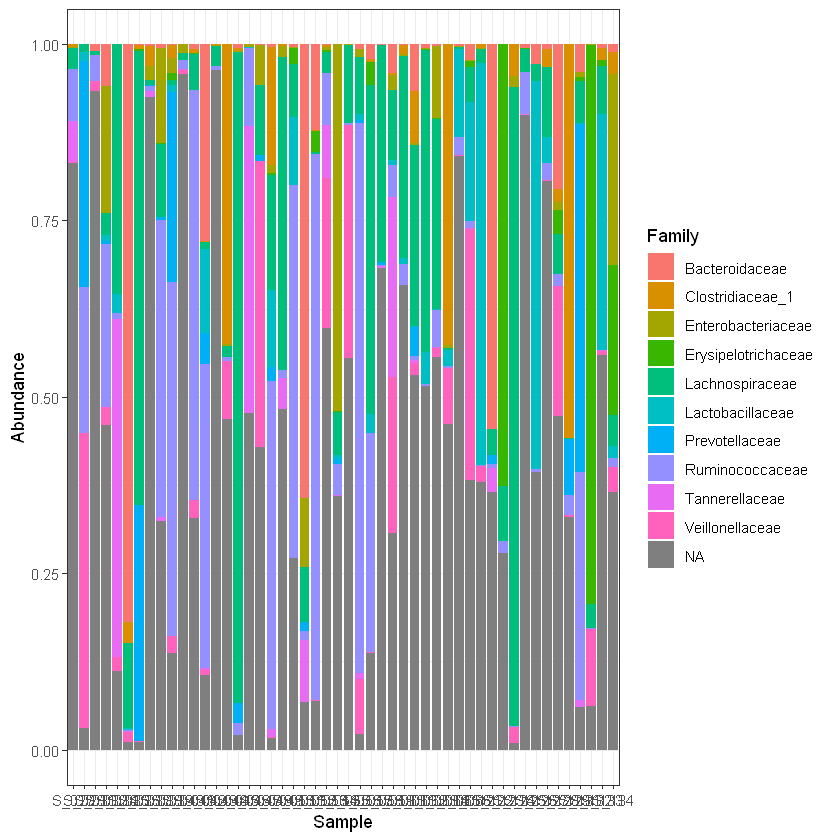

In [26]:
p <- ggplot(phy_df, aes(x = Sample, y = Abundance, fill = Family)) +
  theme_bw() +
  geom_bar(stat = "identity")
p

We can use facet's to split the plot depending on Delivery mode. And we angle the x labels and make them samller.

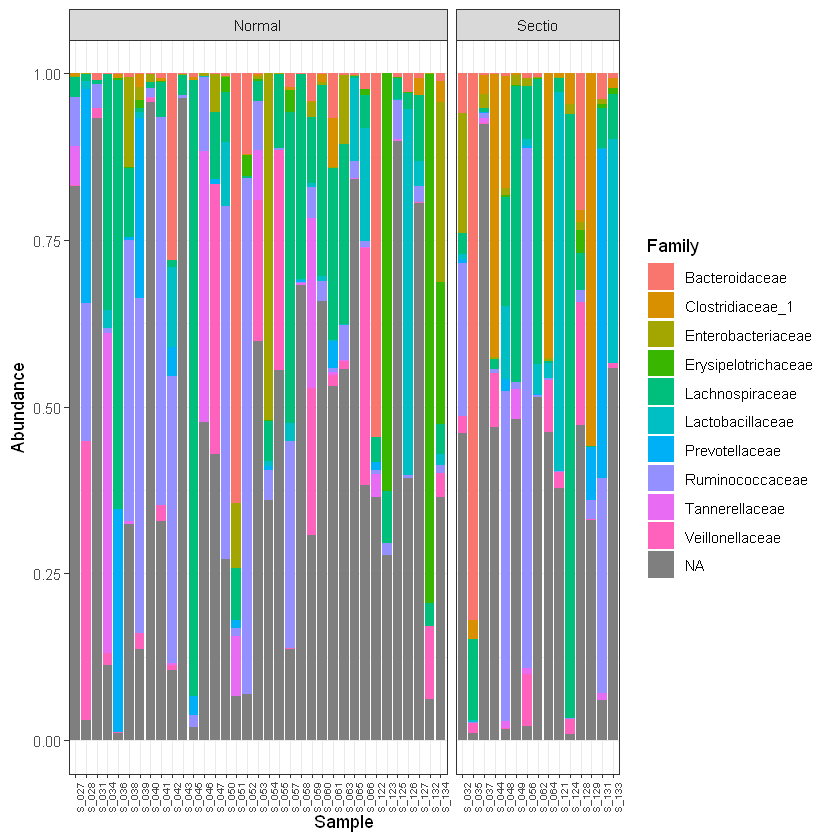

In [27]:
p <- ggplot(phy_df, aes(x = Sample, y = Abundance, fill = Family)) +
  theme_bw() +
  geom_bar(stat = "identity") +
  facet_grid(~ Delivery, space = "free", scales = "free") +
  theme(axis.text.x = element_text(angle=90, size=6))
p